In [1]:
##Generic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload

In [3]:
##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [6]:
import statsmodels.api as sm

In [10]:
from dreamteam.getdata import get_data
from dreamteam.getdata import clean_data

ImportError: cannot import name 'clean_data' from 'dreamteam.getdata' (/Users/anand/.pyenv/versions/3.8.6/envs/dreamteam/lib/python3.8/site-packages/dreamteam/getdata.py)

In [9]:
get_data()

TypeError: get_data() missing 1 required positional argument: 'self'

In [2380]:
file = r'/Users/anand/Documents/Sleep/WSC - variable cross-check_sparse.xlsx'
data = r'/Users/anand/Documents/Sleep/wsc-dataset-0.2.0.csv'

In [2381]:
df = pd.read_excel(file)
data_df = pd.read_csv(data)

In [2382]:
pd.set_option('display.max_columns', None)
#data_df.head()

In [2383]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]

In [2384]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [2385]:

#data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)
##data_df.fillna(0, inplace=True)

In [2386]:
data_df.nasal_cong_none.replace({np.nan:0,'Y':1}, inplace=True)
data_df.num_pregnancies.replace({np.nan:0}, inplace=True)
data_df.packs_week.replace({np.nan:0}, inplace=True)
data_df.pack_years.replace({np.nan:0}, inplace=True)

In [2387]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [2388]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [2389]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df = pd.concat(frames, axis = 1)

##drop original row names

data_df.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

<AxesSubplot:>

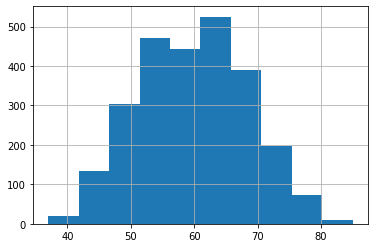

In [2390]:
data_df.age.hist()

# Age restrictions

In [2275]:


#data_df.drop(index = data_df[(data_df.age > 65)].index, inplace=True)

In [2379]:
len(data_df[(data_df.age > 65)])

669

# Process y

In [2276]:
targs = ['sleep_latency','tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds','se', 'waso','sleepiness', 'workday', 'weekend', 'ps_diff', 'ps_diff', 'ps_backsleep','ps_wakerepeat','ps_wakeup','ps_eds']

In [2277]:
imputenum = SimpleImputer(strategy = 'median')
data_df[targs] = imputenum.fit_transform(data_df[targs])


# process X

In [2278]:
X = data_df.drop(columns = targs)
cols= X.columns
X.shape

(1519, 65)

In [2279]:
#### Scaling numerical features - categorical features and targets removed from this listt

numeric_features = ['hdl', 'ldl','total_cholesterol', 'triglycerides', 'weightkg',
       'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam','packs_week', 'pack_years',
       'naps', 'snore_freq',
       'num_pregnancies','age', 'heightcm',
       'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq']

In [2280]:
categoric = data_df.drop(columns = targs)
categoric.drop(columns = numeric_features, inplace=True)
#categoric.drop(columns =['waso', 'wsc_vst'], inplace=True)

In [2281]:
categorical_features = categoric.columns

In [2282]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

In [2283]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())])

In [2284]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),\
        ('cat', categorical_transformer, categorical_features)])

In [2285]:
prepipe = Pipeline(steps=[('preprocessor', preprocessor)])

In [2286]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),('regression', LinearRegression())])

In [2287]:
X = prepipe.fit_transform(X)

In [2288]:
X.shape

(1519, 65)

In [2289]:
X = pd.DataFrame(X, columns = cols)

In [2290]:
X.drop(columns = ['wsc_vst'], inplace=True)

In [2291]:
balance_cutoff = 0.975
imbalanced_classes = []
for col in X.columns:
    _ = X.columns.get_loc(col)
    if X.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
        imbalanced_classes.append((col, X.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

In [2292]:
imbalanced_list = []
for classes in imbalanced_classes:
    imbalanced_list.append(classes[0])

In [2293]:
imbalanced_list

['diabetes_ynd',
 'apnea',
 'androgen_med',
 'stimulants_med',
 'x0_Hyperthyroid',
 'x0_Infection',
 'x0_Nodule',
 'x0_Thyroid Cancer',
 'x0_Unknown']

In [2294]:
X.drop(imbalanced_list, axis=1, inplace=True)

In [2295]:
data_df.shape

(1519, 86)

In [2348]:
waso = data_df.waso
waso = waso.reset_index(drop=True)
waso[(waso <= 48)] = 0
waso[(waso > 48)] = 1


In [2357]:
waso = data_df.waso
waso = waso.reset_index(drop=True)

a = 41
b = 73

waso[(waso < a) | (waso > b)] = 1
waso[(waso >= a) & (waso <= b)] = 0

In [2296]:
se = data_df.se
se = se.reset_index(drop=True)

a = 81
b = 87

se[(se < a) | (se > b)] = 1
se[(se >= a) & (se <= b)] = 0

In [2304]:
tst = data_df.tst
tst = tst.reset_index(drop=True)
a = 358
b = 402

tst[(tst < a) | (tst > b)] = 1
tst[(tst >= a) & (tst <= b)] = 0

In [1548]:
tso = data_df.tso
tso = tso.reset_index(drop=True)

a = 13.7
b = 17

tso[(tso < a) | (tso > b)] = 1
tso[(tso >= a) & (tso <= b)] = 0

((1519,), <AxesSubplot:>)

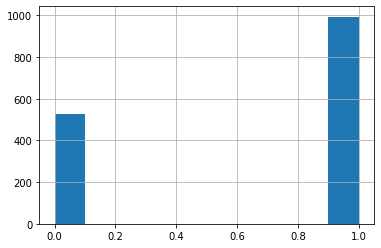

In [2358]:
y = waso
y = y.reset_index(drop=True)
y.shape, y.hist()

In [2359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

In [2360]:
y_train = y_train.astype('int')

In [2361]:
y_train.value_counts()

1    844
0    447
Name: waso, dtype: int64

In [2362]:
#model1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')
model1 = LogisticRegression()

In [2363]:
model1 = RandomForestClassifier()

In [2364]:
cv_results = cross_validate(model1, X_train, y_train, cv=5, scoring=['accuracy', 'recall', 'precision', 'f1'])
sorted(cv_results.keys())
cv_results['test_accuracy'].mean(), cv_results['test_recall'].mean(), cv_results['test_precision'].mean(), cv_results['test_f1'].mean()

(0.6522163359372661,
 0.9466892082276699,
 0.6641758972705611,
 0.7806575041501498)

In [2365]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score

In [2366]:
model1.fit(X_train, y_train)
accuracy_score(y_test, model1.predict(X_test)), recall_score(y_test, model1.predict(X_test))

(0.6491228070175439, 0.9666666666666667)

In [1414]:
dummy = DummyClassifier(strategy = "prior")
dummy.fit(X_train, y_train)


DummyClassifier()

In [1415]:
accuracy_score(y_test, dummy.predict(X_test)), recall_score(y_test, dummy.predict(X_test))

(0.7928994082840237, 1.0)

In [1662]:
X_train.columns.to_list()

['sex',
 'age',
 'race',
 'education_survey1',
 'hdl',
 'ldl',
 'total_cholesterol',
 'triglycerides',
 'heightcm',
 'weightkg',
 'hipgirthm',
 'neckgirthm',
 'waistgirthm',
 'waisthip',
 'sitsysm',
 'sitdiam',
 'cups_coffee',
 'caffeine',
 'alcohol_wk',
 'packs_week',
 'pack_years',
 'eval_general',
 'eval_life',
 'eval_health',
 'naps',
 'snore_freq',
 'snore_vol',
 'choke_freq',
 'apnea_freq',
 'awake_freq',
 'nasal_cong_none',
 'any_cvd',
 'hypertension_ynd',
 'stroke_ynd',
 'asthma_ynd',
 'thyroid_ynd',
 'arthritis_ynd',
 'emphysema_ynd',
 'menopausal_status',
 'num_pregnancies',
 'asthma_med',
 'cholesterol_med',
 'depression_med',
 'htn_med',
 'decongestants_med',
 'antihistamines_med',
 'anxiety_med',
 'diabetes_med',
 'sedative_med',
 'thyroid_med',
 'x0_Hypothyroid',
 'x0_C',
 'x0_N',
 'x0_P']

# Modelling

<AxesSubplot:>

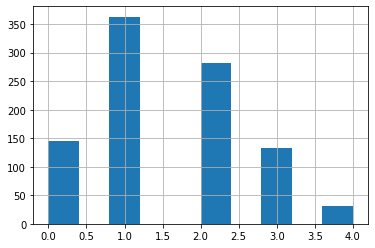

In [681]:
y_train.hist()

In [682]:
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.33)

In [683]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
##, recall_score, precision_score, accuracy_score

In [685]:
cv_results = cross_validate(model1, Xtrain, ytrain, cv=5, scoring=['neg_mean_absolute_error'])
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_neg_mean_absolute_error']

In [686]:
cv_results['test_neg_mean_absolute_error'].mean()

-0.7982318017472406

In [ ]:
model = LogisticRegression(multi_class='ovr', max_iter = 1000)

In [ ]:
model.fit(Xtrain_tr, ytrainbin_tr)
ypred = model.predict(Xtrain_te)

In [118]:
dummy = DummyRegressor(strategy='mean')

In [119]:
dummy.fit(Xtrain, ytrain)

DummyRegressor()

In [120]:
dummy.score(Xval, yval)

-0.0036763961072932005

In [121]:
mean_absolute_error(yval, dummy.predict(Xval))

47.29975706088383

(315, 111)

# Random non-used code

In [ ]:
#WASO parameters


data_df['se_targ'] = 0

#35-49
age1 = 35
age2 = 49
a1 = 83
a2 = 87

#50-64
age3 = 50
age4 = 64
b1 = 81
b2 = 85

#65+
age5 = 65
c1 = 73
c2 = 82


data_df.se_targ[(data_df['age'] >= age1) & (data_df['age'] <= age2)\
        & (data_df['se'] < a1) | (data_df['se'] > a2)] = 1

data_df.se_targ[(data_df['age'] >= age1) & (data_df['age'] <= age2)\
        & (data_df['se'] >= a1) | (data_df['se'] <= a2)] = 0

data_df.se_targ[(data_df['age'] >= age3) & (data_df['age'] <= age4)\
        & (data_df['se'] < b1) | (data_df['se'] > b2)] = 1

data_df.se_targ[(data_df['age'] >= age3) & (data_df['age'] <= age4)\
        & (data_df['se'] >= b1) | (data_df['se'] <= b2)] = 0

data_df.se_targ[(data_df['age'] >= age5)\
        & (data_df['se'] < c1) | (data_df['se'] > c2)] = 1

data_df.se_targ[(data_df['age'] >= age5)\
        & (data_df['se'] >= c1) | (data_df['se'] <= c2)] = 0